# <center> RFM-сегментация клиентов онлайн-магазина

## 1. Постановка задачи

В данном проекте мы решим настоящую бизнес-задачу в области маркетинга. Нам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т.д.

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать модель на новых клиентах.



## 2. Знакомство с данными. 

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import xgboost as xgb
import catboost as cb

from IPython.display import display, HTML

import warnings 
warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.

Для начала познакомимся с нашими данными:

In [2]:
data = pd.read_csv(
    "data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceNo': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

|feature|description|feature|description|
|-|-|-|-|
|`InvoiceNo`|номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции)|`InvoiceDate`|дата и время выставления счёта/проведения транзакции|
|`Stock Code`|код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару)|`UnitPrice`|цена за единицу товара в фунтах стерлингов|
|`Description`|название товара|`CustomerID`|идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту)|
|`Quantity`|количество каждого товара за транзакцию|`Country`|название страны, в которой проживает клиент|



Проведём анализ структуры таблицы.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Как видим, в некоторых колонках имеются пропуски. 

In [4]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Заодно преобразуем столбец InvoiceDate в формат datetime.

In [5]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
min(data['InvoiceDate']), max(data['InvoiceDate'])

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

Это правда: у нас есть данные за целый год + неделя.

Теперь посмотрим, каково максимальное и минимальное количество товаров бывает в заказах и сколько стоит самый дешевый товар (за исключением товаров с отрицательной стоимостью — в таблице встречаются и такие).

In [8]:
print(data.Quantity.describe()[['min', 'max']], '\n')
print('Цена самого дешевого товара:', data.query("UnitPrice >= 0")['UnitPrice'].min()) 

min   -80995.0
max    80995.0
Name: Quantity, dtype: float64 

Цена самого дешевого товара: 0.0


Как видим, есть две транзакции, в одной из которых указано более 80 тысяч единиц товара, а в другой — отрицательное количество товаров (вероятно, это свидетельствует об отмене транзакции). Чтобы понять природу таких транзакций, нам нужно исследовать их более детально.

Также видим, что есть товары, которые «отдаются даром» — они тоже нуждаются в дополнительной проверке.

Посмотрим, сколько уникальных клиентов покупали товары за период выгрузки датасета, сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну), а также сводку по самому часто встречающемуся в заказах id-товара.

In [18]:
print(f'Число уникальных клинтов: {data.CustomerID.nunique()}')
print('Число стран:', data.query("Country != 'Unspecified'").Country.nunique())
print(f'ID самого популярного товара: {data.StockCode.mode()[0]}')
data[data['StockCode'] == data.StockCode.mode()[0]]['Description'].value_counts()

Число уникальных клинтов: 4372
Число стран: 37
ID самого популярного товара: 85123A


Description
WHITE HANGING HEART T-LIGHT HOLDER    2302
CREAM HANGING HEART T-LIGHT HOLDER       9
?                                        1
wrongly marked carton 22804              1
Name: count, dtype: int64

Подвестной светильник в форме сердца был довольно популярен. Также мы видим некоторый "мусор" в данных, где в описании товара находятся служебные записи, принадлежащие, видимо, сотрудникам склада.

## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.

Начнем с пропусков. Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалим строки, содержащие пропуски в этих столбцах.

In [19]:
print('Количество пропущенных данных :', data.isna().sum().sum())

print('Удаление пропусков...')
data = data.dropna(axis=0)

print(f'Число оставшихся строк: {data.shape[0]}')

Количество пропущенных данных : 136534
Удаление пропусков...
Число оставшихся строк: 406829


Следом за пропусками проверим наличие дубликатов и удалим их, если они имеются.

In [20]:
# Найдем дубликаты...
all_columns = list(data.columns)
mask_dupl = data.duplicated(subset=all_columns) 
data_duplicates = data[mask_dupl]
print(f'Количество найденных дубликатов: {data_duplicates.shape[0]}')
print('Удаление дубликатов...')
data.drop_duplicates(inplace=True, ignore_index=True)
print(f'Число оставшихся строк: {data.shape[0]}')

Количество найденных дубликатов: 5225
Удаление дубликатов...
Число оставшихся строк: 401604


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Попробуем разобраться, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [21]:
negative_quantity = data.query("Quantity < 0")
print('Количество записей с отрицательным числом: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Количество записей с отрицательным числом: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Итак, таких записей почти девять тысяч. Не похоже на какую-то ошибку или выбросы, ведь случаев слишком много.

При просмотре таблицы можно заметить следующее:

- Номер заказа (InvoiceNo) и код товара (StockCode) могут содержать не только числа, но и символы.
- Как было сказано в описании датасета, символ "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.
- Код товара может содержать различные специальные символы: например, символ "D", судя по описанию товара (столбец Description), означает наличие скидки.
- Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).

> При анализе таблицы можно было также заметить, что отрицательное количество товаров не всегда сопровождалось признаком возврата (символ "C" перед номером заказа отсутствует). Таких транзакций 1336 штук, и для всех из них не указан идентификатор пользователя (CustomerID). Мы удалили эти транзакции, когда избавлялись от строк с пропущенными айдишниками пользователей.

Проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

In [23]:
print('Число транзакций из таблицы negative_quantity несодержащих в номере заказа признак возврата: ', end='')
print(negative_quantity['InvoiceNo'].apply(lambda x: 0 if 'C' in x else 1).sum())

Число транзакций из таблицы negative_quantity несодержащих в номере заказа признак возврата: 0


Все транзакции с отрицательным количеством товара являются возвратами.

Разберёмся с ними поподробнее. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:

In [24]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head(10)

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


Теперь мы можем трезво оценить, как часто клиенты возвращают товар.

In [25]:
nb_products_per_basket.shape

(22190, 3)

Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

In [26]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if 'C' in x else 0)
print('Доля отмененных заказов:', round(nb_products_per_basket['order_canceled'].mean() * 100, 2), '%')


Доля отмененных заказов: 16.47 %


Более 16 % уникальных заказов являются возвратами.

Интересный факт: если бы мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то количество возвратов было бы менее 1 %. Это некорректное число.

Взглянем поближе на отмененные заказы:

In [28]:
nb_products_per_basket.query("order_canceled == 1").head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [29]:
data.query("CustomerID == '12346'")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
37511,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
37516,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена».

Выдвинем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует ее аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

In [30]:
for index, col in negative_quantity.iterrows():
    if data[
        (data['CustomerID'] == col['CustomerID']) &
        (data['Quantity'] == -col['Quantity']) &
        (data['StockCode'] == col['StockCode'])
    ].shape[0] == 0:
        print(col)
        print('Our initial hypothesis is wrong')
        break

InvoiceNo                  C536379
StockCode                        D
Description               Discount
Quantity                        -1
InvoiceDate    2010-12-01 09:41:00
UnitPrice                     27.5
CustomerID                   14527
Country             United Kingdom
Name: 141, dtype: object
Our initial hypothesis is wrong


Гипотеза не подтвердилась: не все заказы с отрицательным количеством товара имеют в таблице свои аналоги. Нужно дальше разбираться, почему так происходит.

Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [31]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
6521,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
6522,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
6523,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
6524,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратим внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров мы не найдем. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

Выдвигаем новую гипотезу: для каждой отмененной транзакции в базе данных (таблица data) существует ее аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

In [32]:
data_check = negative_quantity.query("StockCode != 'D'")

for index, col in data_check.iterrows():
    if data[
        (data['CustomerID'] == col['CustomerID']) &
        (data['Quantity'] == -col['Quantity']) &
        (data['Description'] == col['Description'])
    ].shape[0] == 0:
        print(col)
        print('The second hypothesis is also wrong')
        break

InvoiceNo                              C536383
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
InvoiceDate                2010-12-01 09:49:00
UnitPrice                                 4.65
CustomerID                               15311
Country                         United Kingdom
Name: 154, dtype: object
The second hypothesis is also wrong


Эта гипотеза тоже не подтвердилась. Даже исключив товары со скидками, мы не можем найти аналогов для некоторых отмененных заказов.

Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:

In [33]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
6750,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
11855,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
18214,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
25143,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
27303,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
37034,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
48630,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
>Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому мы создадим в данных о транзакциях признак `QuantityCanceled`, который будет указывать на количество возвращенного впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отмененная транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращенного товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).

Напишем функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращенного впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаем в таблице с транзакциями новый столбец QuantityCanceled.

In [34]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)

Подсчитаем суммарное количество отмененных товаров в столбце QuantityCanceled.

In [35]:
data['QuantityCanceled'] = quantity_canceled
print(f'Суммарное количество отмененных товаров: {int(data.QuantityCanceled.sum())}')

Суммарное количество отмененных товаров: 245266


Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара.

In [36]:
data.drop(data.query("Quantity < 0").index, axis=0, inplace=True)
print('Число оставшихся строк:', data.shape[0])

Число оставшихся строк: 392732


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Проверим, бывают ли другие специальные коды.

С помощью регулярных выражений найдем такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

In [37]:
special_transaction_data = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=1) == True]
special_transaction_data['StockCode'].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалим все специальные транзакции из таблицы. 

In [38]:
data.drop(special_transaction_data.index, axis=0, inplace=True)
print('Число оставшихся строк:', data.shape[0])

Число оставшихся строк: 391183


Поработаем с ценами на товары.

Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

In [39]:
print('Число транзакций с нулевой ценой за единицу товара:', data.query("UnitPrice == 0").shape[0])

Число транзакций с нулевой ценой за единицу товара: 33


Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалим такие транзакции из таблицы.

In [40]:
data.drop(data.query("UnitPrice == 0").index, axis=0, inplace=True)
print('Число оставшихся строк:', data.shape[0])

Число оставшихся строк: 391150


Этап очистки данных на этом можем считать завершённым. Сохраним полученный результат в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.

In [41]:
data.to_csv('data/data_cleaned.csv', index=False)

## 4. Разведывательный анализ данных

Теперь мы займемся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.

Для начала выясним, в каких странах живут клиенты. Построим график, отражающий количество клиентов в каждой из стран.

In [42]:
country_grouped = data.groupby('Country')['CustomerID'].count().to_frame() \
    .reset_index().sort_values(by='CustomerID', ascending=0)
    
fig = px.choropleth(
    data_frame=country_grouped,
    locations='Country',
    locationmode='country names',
    color='CustomerID',
    title='Count of customer per country',
    width=800,
    height=500,
    color_continuous_scale='jet'
)

fig.show()

Теперь — заказы.

In [43]:
cnt_invvoice_per_cntrs = data.groupby('Country', as_index=False) \
    .InvoiceNo.count().sort_values(by='InvoiceNo', ascending=False)
    
fig = px.bar(
    cnt_invvoice_per_cntrs,
    x='Country',
    y='InvoiceNo',
    color='Country',
    title='Number of orders per country',
    height=500
)

fig.show()

Добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

In [44]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
print('Средняя общая цена заказа:', round(data['TotalPrice'].mean(), 2))

Средняя общая цена заказа: 21.13


Построим еще один график, который поможет нам понять, клиенты из каких стран приносят компании больше всего выручки.

In [45]:
revenue_per_cntrs = data.groupby('Country', as_index=False)['TotalPrice'] \
    .sum().sort_values(by='TotalPrice', ascending=False)

fig = px.bar(
    revenue_per_cntrs,
    x='Country',
    y='TotalPrice',
    color='Country',
    title='Total revenue per country',
    height=500
)

fig.show()

Теперь займёмся временными характеристиками.

Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам.

In [46]:
data['InvoiceMonth'] = data['InvoiceDate'].dt.month
data['InvoiceWeekday'] = data['InvoiceDate'].dt.day_name()
data['InvoiceHour'] = data['InvoiceDate'].dt.hour

revenue_per_month = data.groupby('InvoiceMonth', as_index=False)['TotalPrice'] \
    .sum().sort_values(by='TotalPrice', ascending=False)

fig = px.bar(
    revenue_per_month,
    x='InvoiceMonth',
    y='TotalPrice',
    color='InvoiceMonth',
    title='Total revenue per month'
)

fig.show()

Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

Построим график заказов для каждого дня недели.

In [47]:
revenue_per_weekday = data.groupby('InvoiceWeekday', as_index=False)['TotalPrice'] \
    .sum().sort_values(by='TotalPrice', ascending=False)

fig = px.bar(
    revenue_per_weekday,
    x='InvoiceWeekday',
    y='TotalPrice',
    color='InvoiceWeekday',
    title='Total revenue per month'
)

fig.show()

Согласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.

Выделим дату из признака времени совершения транзакции.
Сгруппируем данные по датам и часам совершения транзакции и найдем количество заказов на каждый день-час. Затем найдем среднее количество ежедневно поступающих заказов в каждый из часов.

Построим график, отражающий распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

In [48]:
data['Date'] = data['InvoiceDate'].dt.date
cnt_invoice_per_date_hour = data.groupby(
    by=['Date', 'InvoiceHour'],
    as_index=False)['InvoiceNo'].count()

mean_cnt_invoice_per_hour = cnt_invoice_per_date_hour \
    .groupby('InvoiceHour', as_index=False)['InvoiceNo'].mean()

fig = px.bar(
    mean_cnt_invoice_per_hour,
    x='InvoiceHour',
    y='InvoiceNo',
    title='Number of orders per hour',
    height=500
)

fig.show()

Больше всего заказов совершается в дневное время в интервале от 10 до 15 часов.

Сохраним проделанную над данными работу.

In [49]:
data.to_csv('data/data_cleaned.csv', index=False)

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого мы познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.

Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на товары (с учетом возвратов).

In [50]:
data_cleaned = pd.read_csv('data/data_cleaned.csv')

now = pd.to_datetime('2011-12-10')
custom_aggregation = {
    'InvoiceDate': lambda x: (now - x.max()).days,
    'InvoiceNo': lambda x: len(x.unique()),
    'TotalPrice': lambda x: x.sum()
}

rfm_table = data.groupby('CustomerID').agg(custom_aggregation) \
    .rename(columns={
        'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'
        })

rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


In [51]:
print('Число клиентов совершивших покупку более 200 дней назад:', rfm_table.query("Recency > 200").shape[0])
print('Среднее число заказов:', round(rfm_table.Frequency.mean()), 'шт.')
print('Общие траты клиента 12360:', round(rfm_table.loc['12360', 'Monetary'], 2), 'ф.с.')

Число клиентов совершивших покупку более 200 дней назад: 743
Среднее число заказов: 4 шт.
Общие траты клиента 12360: 2302.06 ф.с.


Теперь взглянем на коробчатые диаграммы для каждого из признаков:

In [52]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_1.html')
fig.show()

Как можно видеть, имеются клиенты с аномально большим количеством заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.

In [53]:
h_cap_frequency = rfm_table['Frequency'].quantile(0.95)
h_cap_monetary = rfm_table['Monetary'].quantile(0.95)

outliers = rfm_table[
    (rfm_table['Frequency'] > h_cap_frequency) |
    (rfm_table['Monetary'] > h_cap_monetary)
]

print('RFM table shape before:', rfm_table.shape)
rfm_table_cleaned = rfm_table.drop(outliers.index)
print('RFM table shape ffter: ', rfm_table_cleaned.shape)

RFM table shape before: (4334, 3)
RFM table shape ffter:  (4044, 3)



Снова отрисуем наши коробчатые диаграммы:

In [54]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


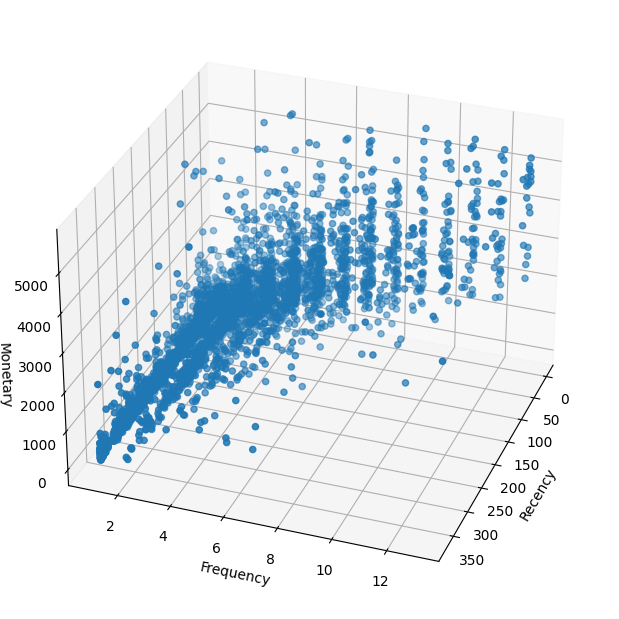

In [55]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Воспользуемся методами снижения размерности.

Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Для удобства обернем эти шаги по предобработке данных в pipeline.

In [56]:
pipeline_preprocessing = pipeline.Pipeline(
    steps=[
        ('scaler', preprocessing.StandardScaler()),
        ('dimension', decomposition.PCA(n_components=2))
    ]
)

rfm_table_processed = pipeline_preprocessing.fit_transform(rfm_table_cleaned)
rfm_table_processed = pd.DataFrame(
    rfm_table_processed,
    columns=['axis-1', 'axis-2'],
    index=rfm_table_cleaned.index
)

print('Доля дисперсии, объясняемой первым компонентом: ', end='')
print(round(pipeline_preprocessing['dimension'].explained_variance_ratio_[0], 2))
print('Доля дисперсии, объясняемой вторым компонентом: ', end='')
print(round(pipeline_preprocessing['dimension'].explained_variance_ratio_[1], 2))

Доля дисперсии, объясняемой первым компонентом: 0.68
Доля дисперсии, объясняемой вторым компонентом: 0.24


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

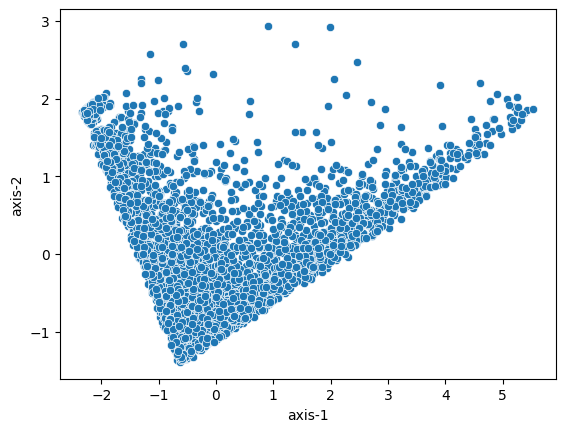

In [57]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Разделим это пространство главных компонент на сегменты.

Попробуем воспользоваться методом k-means. 

Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, индексов Калински-Харабаса и Дэвиса-Болдина, перебирая возможные значения от 2 до 10 включительно.

In [58]:
silhouette, calinski_harabasz, davies_bouldin = dict(), dict(), dict()
# проходимся циклом по всем нужным нам значениям количества кластеров
for n in range(2, 11):
	# обучаем модель k-means с текущим количеством кластеров
    km = cluster.KMeans(n_clusters=n, n_init=10, random_state=42).fit(rfm_table_processed)
	#п редсказываем метки
    preds = km.predict(rfm_table_processed)
	# выводим результат для коэффициента силуэта
    silhouette[n] = metrics.silhouette_score(rfm_table_processed, preds)
    calinski_harabasz[n] = metrics.calinski_harabasz_score(rfm_table_processed, preds)
    davies_bouldin[n] = metrics.davies_bouldin_score(rfm_table_processed, preds)

n_kl_silh = sorted(silhouette, key=lambda x: silhouette[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh}, {round(silhouette[n_kl_silh], 2)}')
n_kl_ch = sorted(calinski_harabasz, key=lambda x: calinski_harabasz[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin, key=lambda x: davies_bouldin[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 3, 0.52
Число кластеров с оптимальным индексом Калински-Харабаса: 6, 6992.59
Число кластеров с оптимальным индексом Дэвиса-Болдина: 3, 0.63


Теперь возьмём EM-алгоритм.

Подберем оптимальное количество кластеров тем же способом.

In [59]:
silhouette_gm, calinski_harabasz_gm, davies_bouldin_gm = dict(), dict(), dict()
# Проходимся циклом по всем нужным нам значениям количества кластеров
for n in range(2, 11):
	# Обучаем модель GaussianMixture с текущим количеством кластеров
    gm_model = mixture.GaussianMixture(n_components=n, random_state=42)
	# Предсказываем метки
    preds_gm = gm_model.fit_predict(rfm_table_processed)
	# Выводим результат для коэффициента силуэта
    silhouette_gm[n] = metrics.silhouette_score(rfm_table_processed, preds_gm, metric='euclidean')
    calinski_harabasz_gm[n] = metrics.calinski_harabasz_score(rfm_table_processed, preds_gm)
    davies_bouldin_gm[n] = metrics.davies_bouldin_score(rfm_table_processed, preds_gm)

n_kl_silh = sorted(silhouette, key=lambda x: silhouette_gm[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh}, {round(silhouette_gm[n_kl_silh], 2)}')
n_kl_ch = sorted(calinski_harabasz, key=lambda x: calinski_harabasz_gm[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz_gm[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin, key=lambda x: davies_bouldin_gm[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin_gm[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 3, 0.44
Число кластеров с оптимальным индексом Калински-Харабаса: 3, 4376.62
Число кластеров с оптимальным индексом Дэвиса-Болдина: 3, 0.72


Посмотрим на распределение кластеров.

In [60]:
# Инициализируем объект
km_model = cluster.KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)
# Обучение
km_model.fit(rfm_table_processed)
# Получение разметки
labels = pd.Series(
    km_model.labels_.astype('str'),
    index=rfm_table_processed.index
)
# Сводка по кластерам
labels.value_counts()

0    2267
2    1001
1     776
Name: count, dtype: int64

Визуализируем результаты кластеризации:

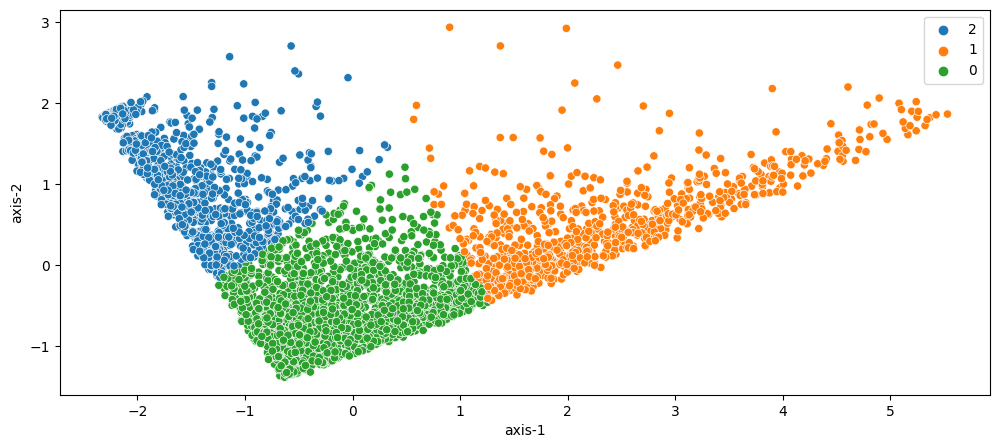

In [61]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [62]:
cluster_grouped = rfm_table_cleaned.groupby(labels).mean()
cluster_grouped.style.background_gradient(cmap='coolwarm')

,Recency,Frequency,Monetary
0,51.127481,2.329069,660.168677
1,31.943299,7.068299,2657.746997
2,253.283716,1.405594,386.598472


### Полярная диаграмма
Сейчас мы воспользуемся одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».

Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник.

Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализуем собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавим в реализацию функции plot_cluster_profile().

In [63]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=500, # ширина (в пикселях)
        height=500, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

Теперь у нас есть удобный инструмент для анализа профиля кластеров.

Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

In [64]:
plot_cluster_profile(cluster_grouped, n_clusters=3)

Кластер `1` соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

Кластер `0` соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».

Кластер `2` соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. PCA является линейным методом отображения исходного пространства признаков в его сжатую версию. А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Опробуем его и посмотрим, что получится.

Итак, воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Для удобства обернем шаги по предобработке данных в pipeline.

Затем рассчитаем значение дивергенции Кульбака-Лейблера для обученного алгоритма t-SNE.

>Дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями.


In [65]:
pipeline_preprocessing = pipeline.Pipeline(
    steps=[
        ('scaler', preprocessing.StandardScaler()),
        ('dimension', manifold.TSNE(
            n_components=2,
            perplexity=50,
            random_state=100
            )
        )
    ]
)

rfm_table_processed = pipeline_preprocessing.fit_transform(rfm_table_cleaned)
rfm_table_processed = pd.DataFrame(
    rfm_table_processed,
    columns=['axis-1', 'axis-2'],
    index=rfm_table_cleaned.index
)

print('Значение дивергенции Кульбака-Лейблера:', round(pipeline_preprocessing['dimension'].kl_divergence_, 2))

Значение дивергенции Кульбака-Лейблера: 0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


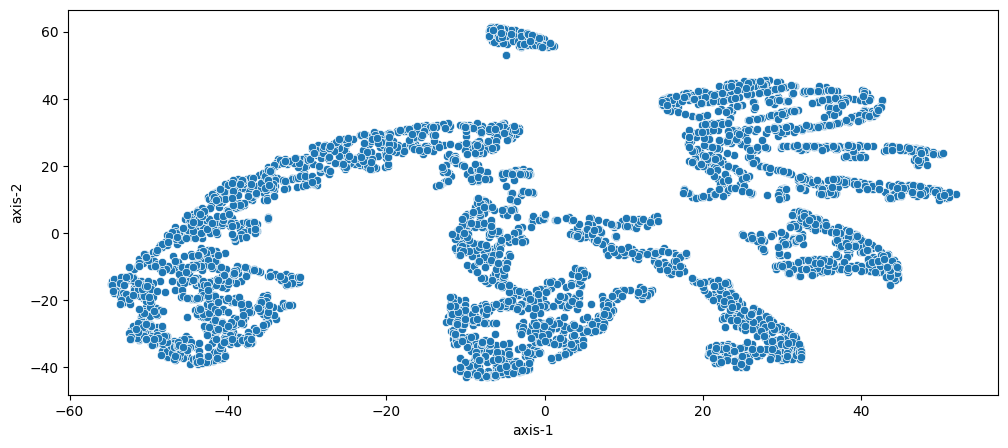

In [66]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.

Первым будет метод k-means. Подберем оптимальное количество кластеров, как мы это делали ранее.

In [67]:
silhouette, calinski_harabasz, davies_bouldin = dict(), dict(), dict()
# проходимся циклом по всем нужным нам значениям количества кластеров
for n in range(3, 9):
	# обучаем модель k-means с текущим количеством кластеров
    km = cluster.KMeans(n_clusters=n, n_init=10, random_state=42).fit(rfm_table_processed)
	#п редсказываем метки
    preds = km.predict(rfm_table_processed)
	# выводим результат для коэффициента силуэта
    silhouette[n] = metrics.silhouette_score(rfm_table_processed, preds)
    calinski_harabasz[n] = metrics.calinski_harabasz_score(rfm_table_processed, preds)
    davies_bouldin[n] = metrics.davies_bouldin_score(rfm_table_processed, preds)

n_kl_silh = sorted(silhouette, key=lambda x: silhouette[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh},', round(silhouette[n_kl_silh], 2))
n_kl_ch = sorted(calinski_harabasz, key=lambda x: calinski_harabasz[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin, key=lambda x: davies_bouldin[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 7, 0.48
Число кластеров с оптимальным индексом Калински-Харабаса: 8, 5896.91
Число кластеров с оптимальным индексом Дэвиса-Болдина: 7, 0.67


Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture).

In [68]:
silhouette_gm, calinski_harabasz_gm, davies_bouldin_gm = dict(), dict(), dict()
# Проходимся циклом по всем нужным нам значениям количества кластеров
for n in range(2, 11):
	# Обучаем модель GaussianMixture с текущим количеством кластеров
    gm_model = mixture.GaussianMixture(n_components=n, random_state=42)
	# Предсказываем метки
    preds_gm = gm_model.fit_predict(rfm_table_processed)
	# Выводим результат для коэффициента силуэта
    silhouette_gm[n] = metrics.silhouette_score(rfm_table_processed, preds_gm, metric='euclidean')
    calinski_harabasz_gm[n] = metrics.calinski_harabasz_score(rfm_table_processed, preds_gm)
    davies_bouldin_gm[n] = metrics.davies_bouldin_score(rfm_table_processed, preds_gm)

n_kl_silh = sorted(silhouette, key=lambda x: silhouette_gm[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh},', round(silhouette_gm[n_kl_silh], 2))
n_kl_ch = sorted(calinski_harabasz, key=lambda x: calinski_harabasz_gm[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz_gm[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin, key=lambda x: davies_bouldin_gm[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin_gm[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 4, 0.47
Число кластеров с оптимальным индексом Калински-Харабаса: 4, 4648.4
Число кластеров с оптимальным индексом Дэвиса-Болдина: 7, 0.69


Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

In [69]:
silhouette_ac, calinski_harabasz_ac, davies_bouldin_ac = dict(), dict(), dict()
# Проходимся циклом по всем нужным нам значениям количества кластеров
for n in range(2, 9):
	# Обучаем модель AgglomerativeClustering с текущим количеством кластеров
    agglomerative = cluster.AgglomerativeClustering(metric='euclidean', n_clusters=n).fit_predict(rfm_table_processed)
	# Выводим результат для коэффициента силуэта
    silhouette_ac[n] = metrics.silhouette_score(rfm_table_processed, agglomerative, metric='euclidean')
    calinski_harabasz_ac[n] = metrics.calinski_harabasz_score(rfm_table_processed, agglomerative)
    davies_bouldin_ac[n] = metrics.davies_bouldin_score(rfm_table_processed, agglomerative)

n_kl_silh = sorted(silhouette_ac, key=lambda x: silhouette_ac[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh},', round(silhouette_ac[n_kl_silh], 2))
n_kl_ch = sorted(calinski_harabasz_ac, key=lambda x: calinski_harabasz_ac[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz_ac[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin_ac, key=lambda x: davies_bouldin_ac[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin_ac[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 8, 0.48
Число кластеров с оптимальным индексом Калински-Харабаса: 8, 5421.24
Число кластеров с оптимальным индексом Дэвиса-Болдина: 8, 0.64


Посмотрим на распределение кластеров.

Сначала нужно определить лучшую модель. Коэффициент силуэта наибольший у алгоритма KMeans.

In [70]:
# Инициализируем объект
km_model = cluster.KMeans(
    n_clusters=7,
    random_state=42,
    n_init=10
)
# Обучение
km_model.fit(rfm_table_processed)

labels = pd.Series(
    km_model.labels_.astype('str'),
    index=rfm_table_processed.index
)

labels.value_counts()

1    914
5    683
0    656
2    543
4    446
6    405
3    397
Name: count, dtype: int64

Визуализируем результаты кластеризации:

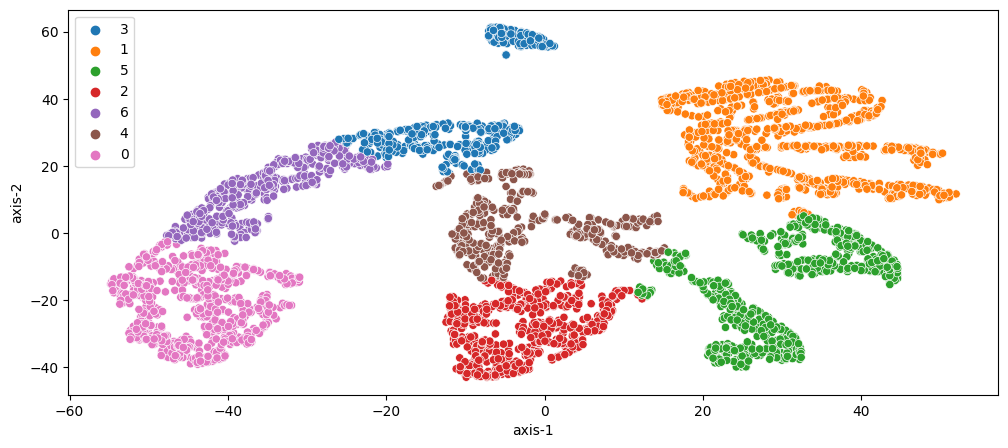

In [71]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed,
    x='axis-1', y='axis-2',
    hue=km_model.labels_.astype('str')
);


Итак, у нас есть 7 сегментов клиентов. Составим профиль для этих сегментов.

Для этого нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков. Для наглядности округлим все значения в столбцах до целого числа.

In [72]:
cluster_grouped = rfm_table_cleaned.groupby(labels).mean()
cluster_grouped.style.background_gradient(cmap='coolwarm')

,Recency,Frequency,Monetary
0,46.329268,1.000000,321.538796
1,32.400438,6.770241,2416.582451
2,40.022099,1.979742,613.663941
3,313.000000,1.012594,261.105315
4,195.800448,2.441704,670.317960
5,40.149341,3.450952,995.197350
6,181.439506,1.000000,273.465160


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

In [73]:
plot_cluster_profile(cluster_grouped, n_clusters=7)

Кластер `1` соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

Кластер `5` соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.

Кластер `2` соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».

Кластер `4` соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.

Кластер `0` соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 

Кластер `6` соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.

Кластер `3` соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов. Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Поэтому на таком этапе задачу кластеризации полезно свести к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

In [74]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned #очищенная RFM-таблица
y = labels #метки кластеров, предсказанные ранее

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20.

In [75]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print('Число клиентов в тестовой выборке:', X_test.shape[0])

Число клиентов в тестовой выборке: 809


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую.

Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут.

Поэтому сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. Начнём со случайного леса.

In [90]:
# Инициализация объекта
rfc = ensemble.RandomForestClassifier(
    random_state=42
)
# Обучение
rfc.fit(X_train, y_train)
# Предсказание
test_preds_rfc = rfc.predict(X_test)
# Вывод метрик
print(metrics.classification_report(y_test, test_preds_rfc, digits=4))

              precision    recall  f1-score   support

           0     0.9929    1.0000    0.9964       140
           1     0.9891    0.9945    0.9918       183
           2     1.0000    0.9817    0.9907       109
           3     0.9857    0.9718    0.9787        71
           4     0.9684    0.9787    0.9735        94
           5     0.9774    0.9774    0.9774       133
           6     0.9747    0.9747    0.9747        79

    accuracy                         0.9852       809
   macro avg     0.9840    0.9827    0.9833       809
weighted avg     0.9852    0.9852    0.9852       809



Итак, значение метрики accuracy очень высокое, но не идеальное. Попробуем его улучшить, воспользовавшись бустингом.

In [91]:
# Инициализация объекта
hgbc = ensemble.HistGradientBoostingClassifier(
    random_state=42
)
# Обучение
hgbc.fit(X_train, y_train)
# Предсказание
test_preds_hgbc = hgbc.predict(X_test)
# Вывод метрик
print(metrics.classification_report(y_test, test_preds_hgbc, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       140
           1     0.9837    0.9891    0.9864       183
           2     0.9908    0.9908    0.9908       109
           3     0.9718    0.9718    0.9718        71
           4     0.9583    0.9787    0.9684        94
           5     0.9923    0.9699    0.9810       133
           6     0.9747    0.9747    0.9747        79

    accuracy                         0.9839       809
   macro avg     0.9817    0.9822    0.9819       809
weighted avg     0.9840    0.9839    0.9839       809



In [112]:
# Инициализация кодировщика
le = preprocessing.LabelEncoder()
# Кодировка лейблов
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

# Инициализация объекта
xgbc = xgb.XGBClassifier()
# Обучение
xgbc.fit(X_train, y_train_le)
# Предсказание
test_preds_xgbc = xgbc.predict(X_test)
# Вывод метрик
print(metrics.classification_report(y_test_le, test_preds_xgbc, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       140
           1     0.9838    0.9945    0.9891       183
           2     1.0000    1.0000    1.0000       109
           3     0.9855    0.9577    0.9714        71
           4     0.9688    0.9894    0.9789        94
           5     1.0000    0.9699    0.9847       133
           6     0.9630    0.9873    0.9750        79

    accuracy                         0.9876       809
   macro avg     0.9859    0.9856    0.9856       809
weighted avg     0.9878    0.9876    0.9876       809



In [96]:
# Инициализация объекта
cbc = cb.CatBoostClassifier(
    verbose=False,
    random_state=42
)
# Обучение
cbc.fit(X_train, y_train)
# Предсказание
test_preds_cbc = cbc.predict(X_test)
# Вывод метрик
print(metrics.classification_report(y_test, test_preds_cbc, digits=4))

              precision    recall  f1-score   support

           0     0.9929    1.0000    0.9964       140
           1     0.9891    0.9945    0.9918       183
           2     1.0000    1.0000    1.0000       109
           3     0.9857    0.9718    0.9787        71
           4     0.9688    0.9894    0.9789        94
           5     1.0000    0.9774    0.9886       133
           6     0.9747    0.9747    0.9747        79

    accuracy                         0.9889       809
   macro avg     0.9873    0.9868    0.9870       809
weighted avg     0.9890    0.9889    0.9889       809



Проведем избранные нами алгоритмы через кросс-валидацию.

Сперва напишем функцию для вывода агрегированных метрик валидированных моделей.

In [109]:
def cv_scores(model, X, y, cv=10):
    """
    Функция кросс-валидации модели.
    Args:
        model: объект, который будет обучаться на данных;
        X (np.array): матрица данных;
        y (np.array): вектор целевой переменной;
        cv (int, cross-validation generator):
            число фолдов кросс-валидации, либо cross-validation estimator.
    Returns:
        array: вектор метрик тествовой выборки.
    """
    if str(model).split('(')[0][:4] == 'XGBC':
        le = preprocessing.LabelEncoder()
        y_le = le.fit_transform(y)
        scores = model_selection.cross_validate(
            model, X, y_le, cv=cv,
            scoring=('precision_weighted', 'recall_weighted', 'f1_weighted', 'accuracy')
        )
    else:
        scores = model_selection.cross_validate(
            model, X, y, cv=cv,
            scoring=('precision_weighted', 'recall_weighted', 'f1_weighted', 'accuracy')
        )
    
     
    precision_test = np.mean(scores['test_precision_weighted'])
    recall_test = np.mean(scores['test_recall_weighted'])
    f1_test = np.mean(scores['test_f1_weighted'])
    accuracy_test = np.mean(scores['test_accuracy'])
    
    test_array = np.array([
        precision_test, recall_test, f1_test, accuracy_test
    ])
    
    return test_array

Проведем в цикле все алгоритмы через нашу функцию и сведем все метрики в сводную таблицу.

In [111]:
models = [
    rfc, hgbc, xgbc, cbc
]

models_test_scores = []

for model in models:
    test_scores = cv_scores(model, X, y)
    models_test_scores.append(np.round(test_scores, 4))

test_results = pd.DataFrame(
    index=[str(model).split('(')[0] if model is not cbc else str(cbc).split()[0].split('.')[2] for model in models],
    columns=['precision', 'recall', 'f1', 'accuracy'],
    data=models_test_scores
)

print('Test scores:')
test_results

Test scores:


,precision,recall,f1,accuracy
RandomForestClassifier,0.9902,0.9901,0.9901,0.9901
HistGradientBoostingClassifier,0.9908,0.9906,0.9906,0.9906
XGBClassifier,0.9915,0.9913,0.9913,0.9913
CatBoostClassifier,0.9917,0.9916,0.9916,0.9916


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модели, которые на основе RFM-характерик клиента автоматически определяет его сегмент с точностью 99%.